In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline
import matplotlib
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [83]:
missing_values = ["n/a", "na", "--","NaN"]
col_names = ['website_price','no_of_travellers','departure_time','duration','cruise_id','conversion','booking_value']
# Importing the dataset
dataset = pd.read_csv('/media/hasan/ec42e2af-0eaa-4b8c-81d5-f2a23ec16363/Downloads/leads.csv',names=col_names, na_values=missing_values,header=None)


# A. Descriptive Statistics of the dataset

In [34]:
dataset.head()

,website_price,no_of_travellers,departure_time,duration,cruise_id,conversion,booking_value
0,4115.0,2,234.0,6.0,737.0,1,118.0
1,1758.0,2,332.0,6.0,71.0,1,165.0
2,NaN,2,28.0,1.0,107.0,1,209.0
3,2913.0,2,246.0,12.0,72.0,1,209.0
4,2240.0,2,198.0,12.0,938.0,1,209.0


In [35]:
dataset.describe()

,website_price,no_of_travellers,departure_time,duration,cruise_id,conversion,booking_value
count,1.461700e+04,19816.000000,19814.000000,19814.000000,19557.000000,19816.000000,2095.000000
mean,6.362362e+03,2.589069,206.281619,10.003381,616.812395,0.105723,5003.266348
std,3.125673e+04,1.129889,145.517137,9.752540,445.637858,0.307490,3723.686874
min,1.230000e+02,1.000000,7.000000,-1.000000,71.000000,0.000000,118.000000
25%,2.680000e+03,2.000000,92.000000,7.000000,127.000000,0.000000,2699.500000
50%,4.308000e+03,2.000000,183.000000,7.000000,725.000000,0.000000,4185.000000
75%,6.860000e+03,3.000000,281.000000,12.000000,1030.000000,0.000000,6170.000000
max,3.667454e+06,15.000000,871.000000,209.000000,1481.000000,1.000000,45974.000000


Text(0.5, 1.0, 'conversion vs website price')

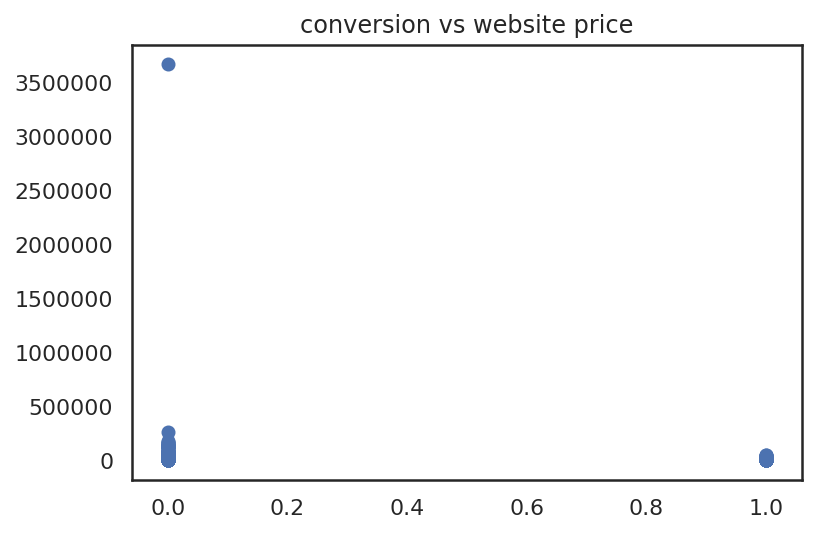

In [36]:
plt.scatter(dataset.conversion,dataset.website_price)
plt.title("conversion vs website price")

Text(0.5, 1.0, 'conversion vs departuretime')

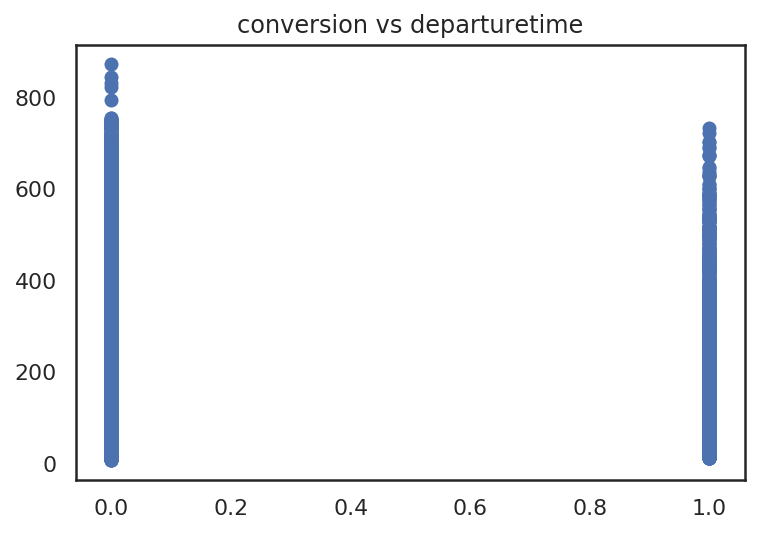

In [37]:
plt.scatter(dataset.conversion,dataset.departure_time)
plt.title("conversion vs departuretime")

Text(0.5, 1.0, 'conversion vs cruse id')

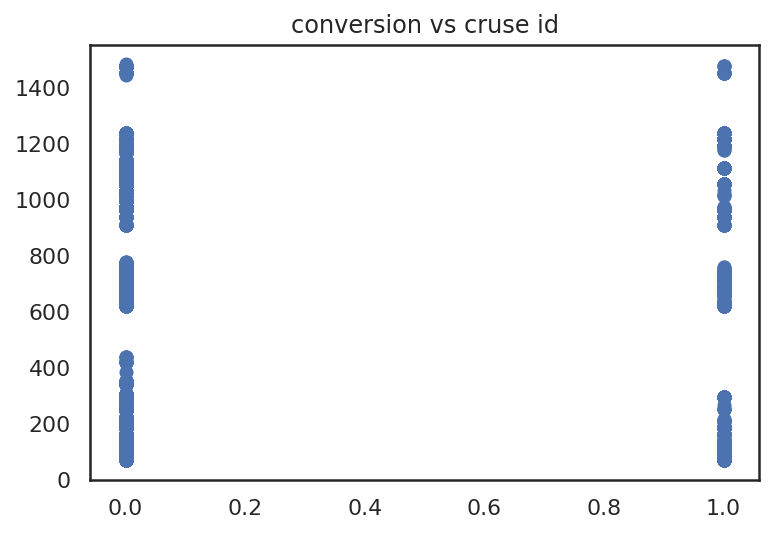

In [38]:
plt.scatter(dataset.conversion,dataset.cruise_id)
plt.title("conversion vs cruse id")

In [39]:

#count the missing values, as there are lot of missing values in this dataset

missing_values = dataset.isnull().sum()
missing_values
new_data =dataset.copy()

*****As the dataset has lot of missing value, 2 in departure_time , 2 in duration, 259 in cruise_id, 5199 in website_price and 17721 in booking_value. I am going to replace missing values for first 2 column with the mean value of the column and for the next 2 i will use rgression algorithm to predict missing value and replace that. For booking value i am notdoing anything as it is not necessary for booking probability prediction
*****

In [41]:
#Fill less missing values column departure time and duration
mean_value = new_data['departure_time'].mean()
new_data['departure_time'] = new_data['departure_time'].fillna(mean_value)
#Duration
mean_value = new_data['duration'].mean()

new_data['duration'] = new_data['duration'].fillna(mean_value)

In [42]:
#re-cheack the missing values
missing_values = new_data.isnull().sum()
missing_values


website_price        5199
no_of_travellers        0
departure_time          0
duration                0
cruise_id             259
conversion              0
booking_value       17721
dtype: int64

In [43]:
# Find Missing Ratio of Dataset
all_data_na = (new_data.isnull().sum() / len(new_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:7]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
booking_value,89.427735
website_price,26.236375
cruise_id,1.307025


Text(0.5, 1.0, 'Percent missing data by feature')

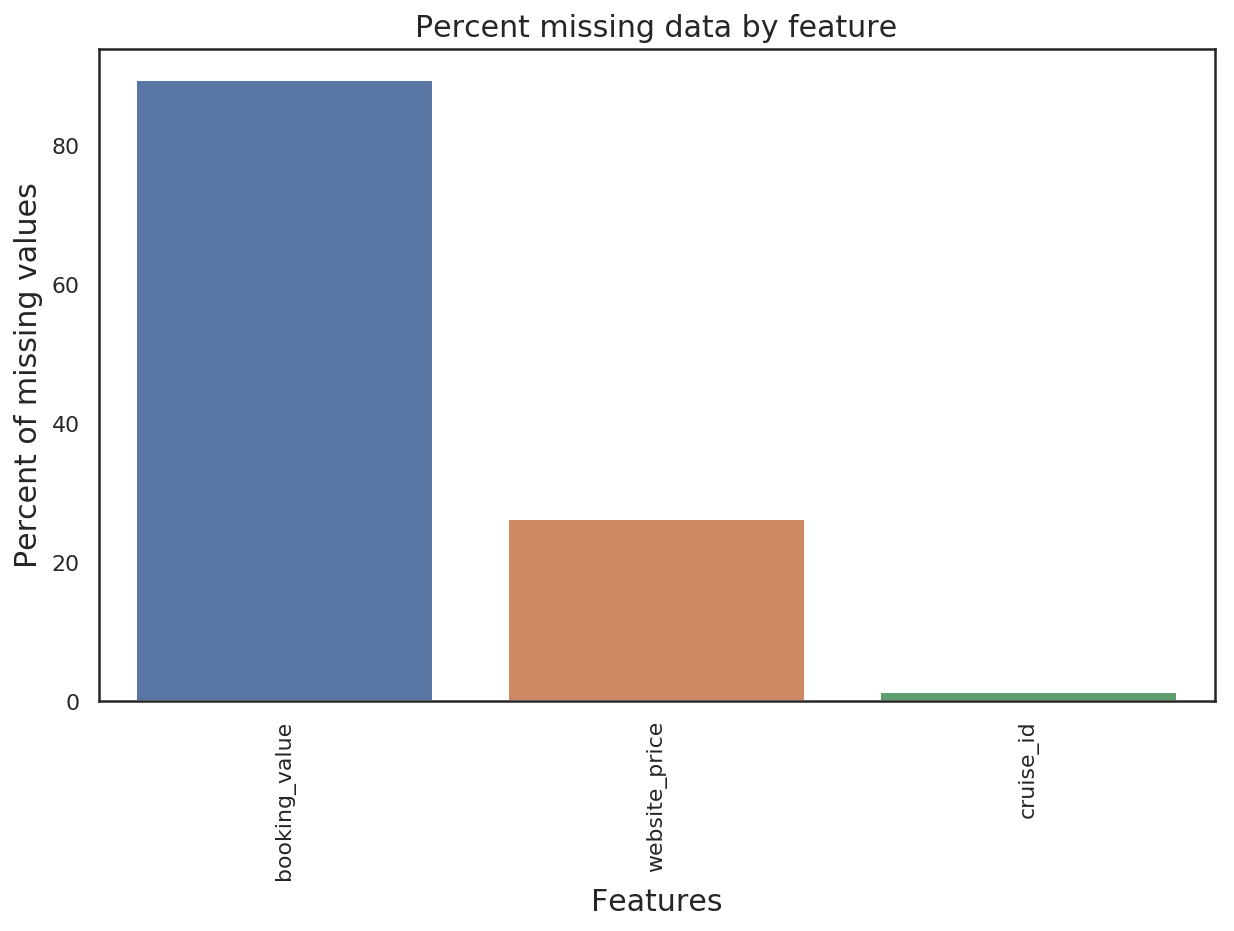

In [44]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Simple correlation plot for the dataset . It is visible that only duration has strong correlation with booking value. For booking probabilty there is not that much strong correlation with any of the variables. Only duration has less strong correlation with conversion. That going to be interesting.

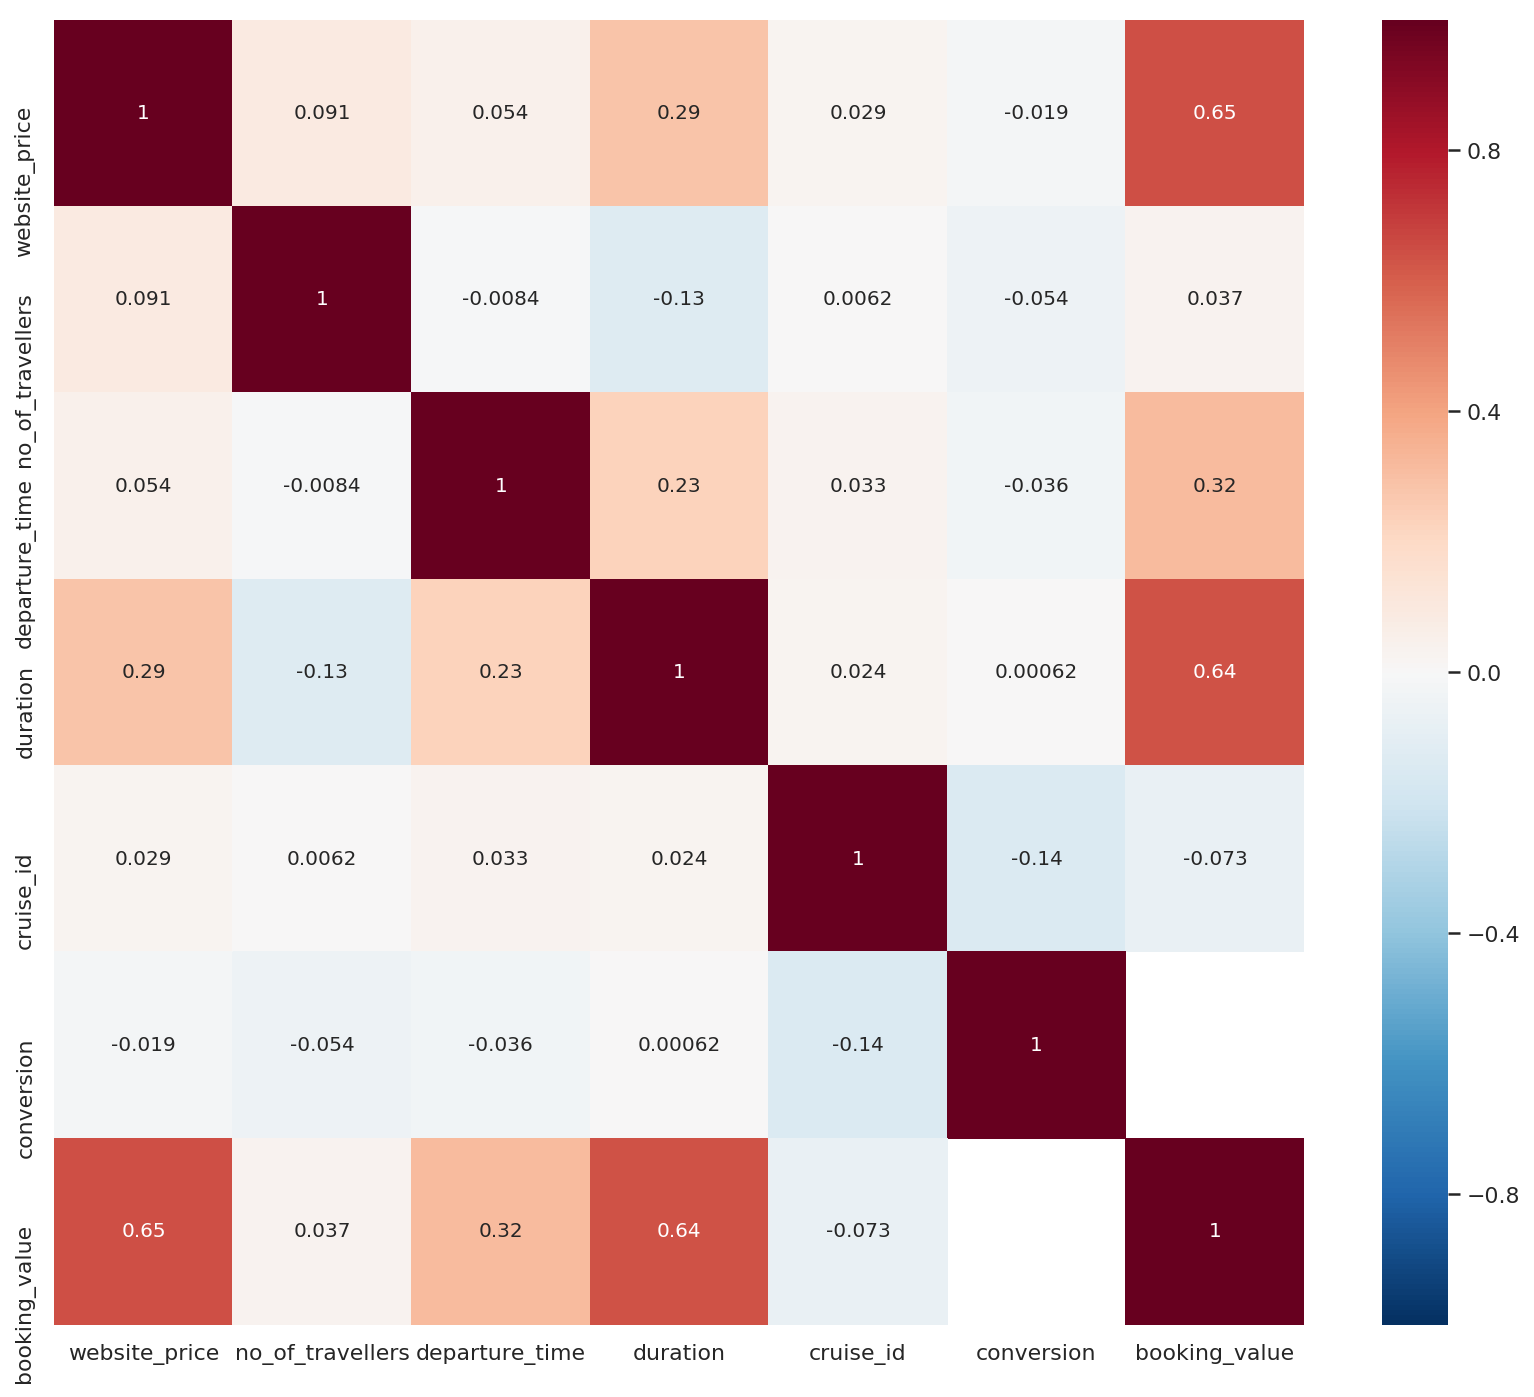

In [46]:
correlation = new_data.corr()
# display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

# Lets replace the missing values for website_price and cruise_id column
1. I used Support Vector Regressor to predict the missing value, it looks okay to me.

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

regressor = LinearRegression()
poly_reg = PolynomialFeatures(degree=2)

data_with_nan = new_data[["no_of_travellers","duration","departure_time","conversion","cruise_id"]]

data_without_nan = data_with_nan.dropna()
print(data_without_nan.shape)


#all column except cruise_id
train_data_x = data_without_nan.iloc[:,:4]
#Only cruise_id
train_data_y = data_without_nan.iloc[:,4]

#Training
x_poly = poly_reg.fit_transform(train_data_x)
regressor.fit(x_poly,train_data_y)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(train_data_x,train_data_y)
classifier = SVR(gamma='scale', C=1.0, epsilon=0.2)
classifier.fit(train_data_x,train_data_y)
#Predict and repalce only missing values
test_data = data_with_nan.iloc[:,:4]
cruise_id_predic = data_with_nan.copy()
#cruise_id_predic['cruise_id'] = pd.DataFrame(regressor.predict(poly_reg.fit_transform(test_data)))
cruise_id_predic['cruise_id'] = pd.DataFrame(classifier.predict(test_data))

#Replace nan value
data_with_nan.cruise_id.fillna(cruise_id_predic.cruise_id,inplace=True)
new_data_1 = data_with_nan.copy()
new_data_1["website_price"] = new_data["website_price"]

(19557, 5)


In [48]:
new_data_1.head()

,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price
0,2,6.0,234.0,1,737.0,4115.0
1,2,6.0,332.0,1,71.0,1758.0
2,2,1.0,28.0,1,107.0,NaN
3,2,12.0,246.0,1,72.0,2913.0
4,2,12.0,198.0,1,938.0,2240.0


In [50]:
#re-cheack the missing values
missing_values = new_data_1.isnull().sum()
missing_values

no_of_travellers       0
duration               0
departure_time         0
conversion             0
cruise_id              0
website_price       5199
dtype: int64

# Replace  missing value for website-price. 

In [51]:
data_with_nan_1 = new_data_1[["no_of_travellers","duration","departure_time","conversion","cruise_id","website_price"]]

data_without_nan_1 = data_with_nan_1.dropna()
print(data_without_nan_1.shape)


#all column except cruise_id
train_data_x = data_without_nan_1.iloc[:,:5]
#Only cruise_id
train_data_y = data_without_nan_1.iloc[:,5]

#Training
x_poly = poly_reg.fit_transform(train_data_x)
regressor.fit(x_poly,train_data_y)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(train_data_x,train_data_y)
classifier = SVR(gamma='scale', C=1.0, epsilon=0.2)
classifier.fit(train_data_x,train_data_y)
#Predict and repalce only missing values
test_data = data_with_nan_1.iloc[:,:5]
website_price_predic = data_with_nan_1.copy()
#website_price_predic['website_price'] = pd.DataFrame(regressor.predict(poly_reg.fit_transform(test_data)))
website_price_predic['website_price'] = pd.DataFrame(classifier.predict(test_data))


#Replace nan value
data_with_nan_1.website_price.fillna(website_price_predic.website_price,inplace=True)
new_data_2 = data_with_nan_1.copy()
new_data_bp = data_with_nan_1.copy()

new_data_2["booking_value"] = new_data["booking_value"]
#repeat again for booking value
#Checking correltion

# display(correlation)
#plt.figure(figsize=(14, 12))
#heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
print(new_data_bp.shape)

(14617, 6)
(19816, 6)


In [52]:
new_data_bp.head()

,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price
0,2,6.0,234.0,1,737.0,4115.000000
1,2,6.0,332.0,1,71.0,1758.000000
2,2,1.0,28.0,1,107.0,4011.224187
3,2,12.0,246.0,1,72.0,2913.000000
4,2,12.0,198.0,1,938.0,2240.000000


In [53]:
data_with_nan_2 = new_data_2[["no_of_travellers","duration","departure_time","conversion","cruise_id","website_price","booking_value"]]
new_data_bb = data_with_nan_2.copy()
new_data_bb = new_data_bb.dropna()

data_without_nan_2 = data_with_nan_2.dropna()

In [54]:
new_data_bb.head()

,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price,booking_value
0,2,6.0,234.0,1,737.0,4115.000000,118.0
1,2,6.0,332.0,1,71.0,1758.000000,165.0
2,2,1.0,28.0,1,107.0,4011.224187,209.0
3,2,12.0,246.0,1,72.0,2913.000000,209.0
4,2,12.0,198.0,1,938.0,2240.000000,209.0


# No more missing value, All set. Lets go forward

In [55]:
print(data_without_nan_2.shape)
missing_values = new_data_bb.isnull().sum()
missing_values

(2095, 7)


no_of_travellers    0
duration            0
departure_time      0
conversion          0
cruise_id           0
website_price       0
booking_value       0
dtype: int64

# Gaussian distribution of the booking value volumn



 mu = 5003.27 and sigma = 3722.80



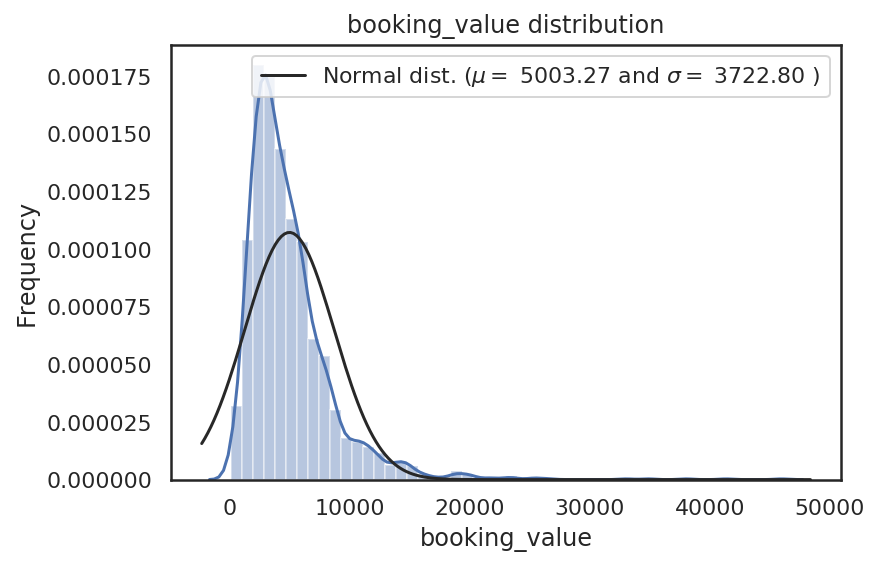

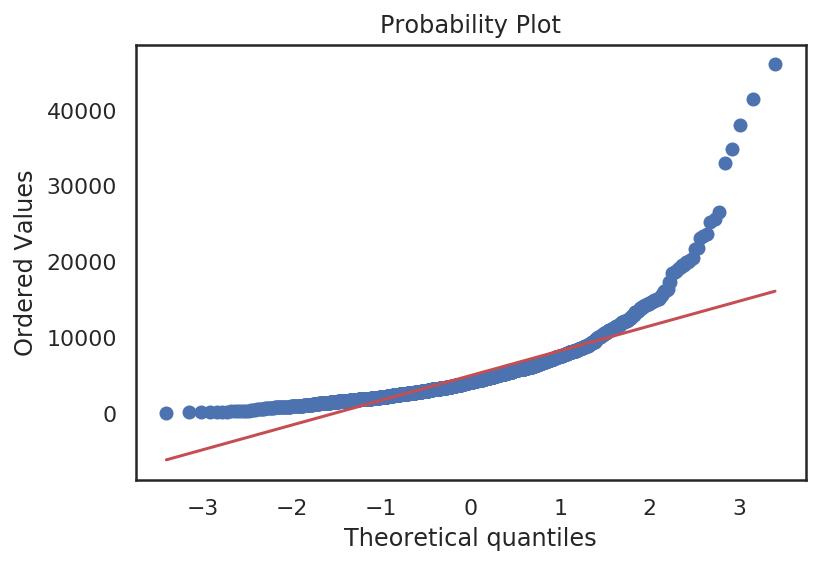

Skewness: 3.232265
Kurtosis: 20.594790


In [56]:
from scipy.stats import norm
# Plot Histogram
sns.distplot(new_data_bb['booking_value'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(new_data_bb['booking_value'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('booking_value distribution')

fig = plt.figure()
res = stats.probplot(new_data_bb['booking_value'], plot=plt)
plt.show()

print("Skewness: %f" % new_data_bb['booking_value'].skew())
print("Kurtosis: %f" % new_data_bb['booking_value'].kurt())

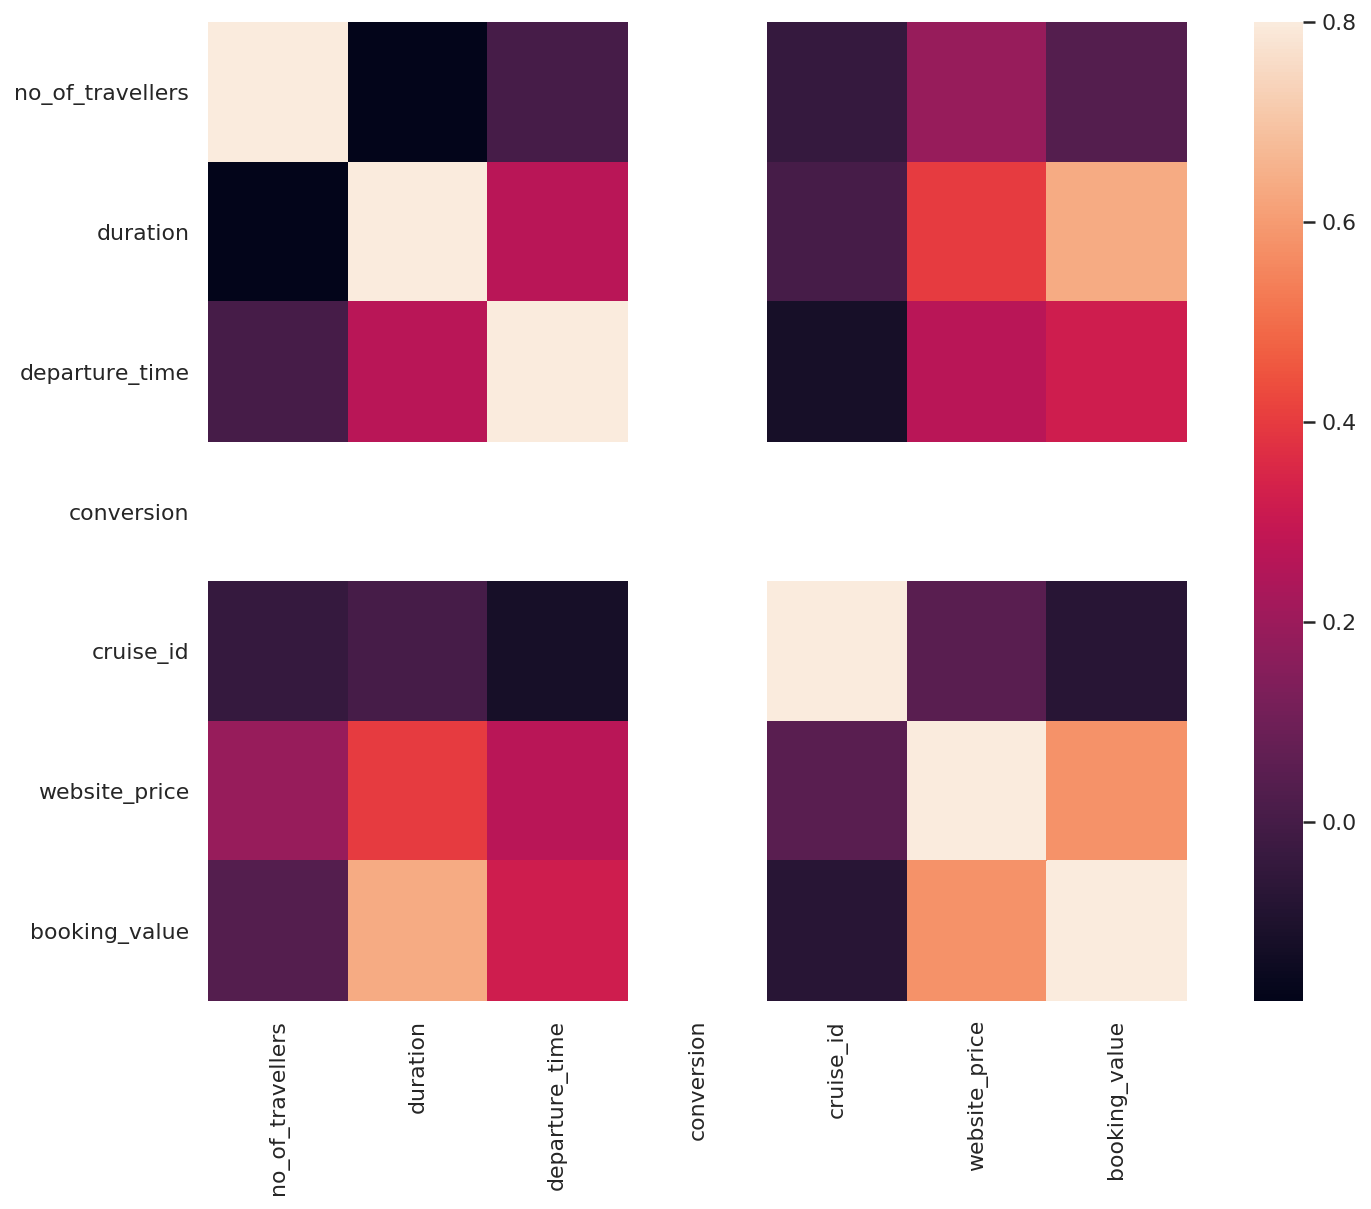

In [58]:
# Correlation Matrix Heatmap
corrmat = new_data_bb.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# Ranking of important feautres for booking value prediction with correlation map

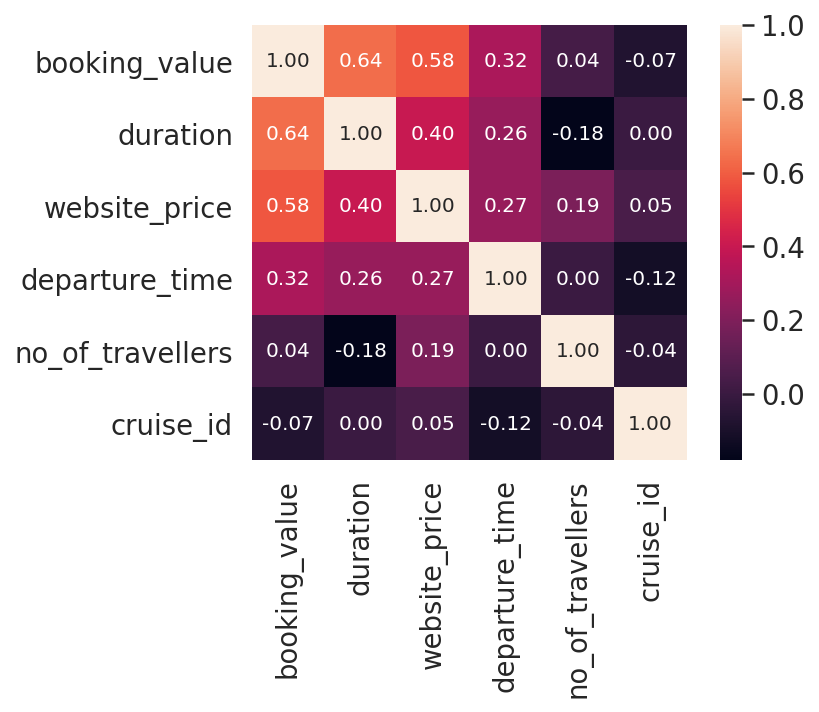

In [59]:
# Top 10 Heatmap
k = 7#number of variables for heatmap
cols = corrmat.nlargest(k, 'booking_value')['booking_value'].index
cm = np.corrcoef(new_data_bb[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We can see duration has highest significance level 

In [62]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,booking_value
1,duration
2,website_price
3,departure_time
4,no_of_travellers
5,cruise_id


# duration vs bookign value plot. We can see how long duration is casuing more booking value.

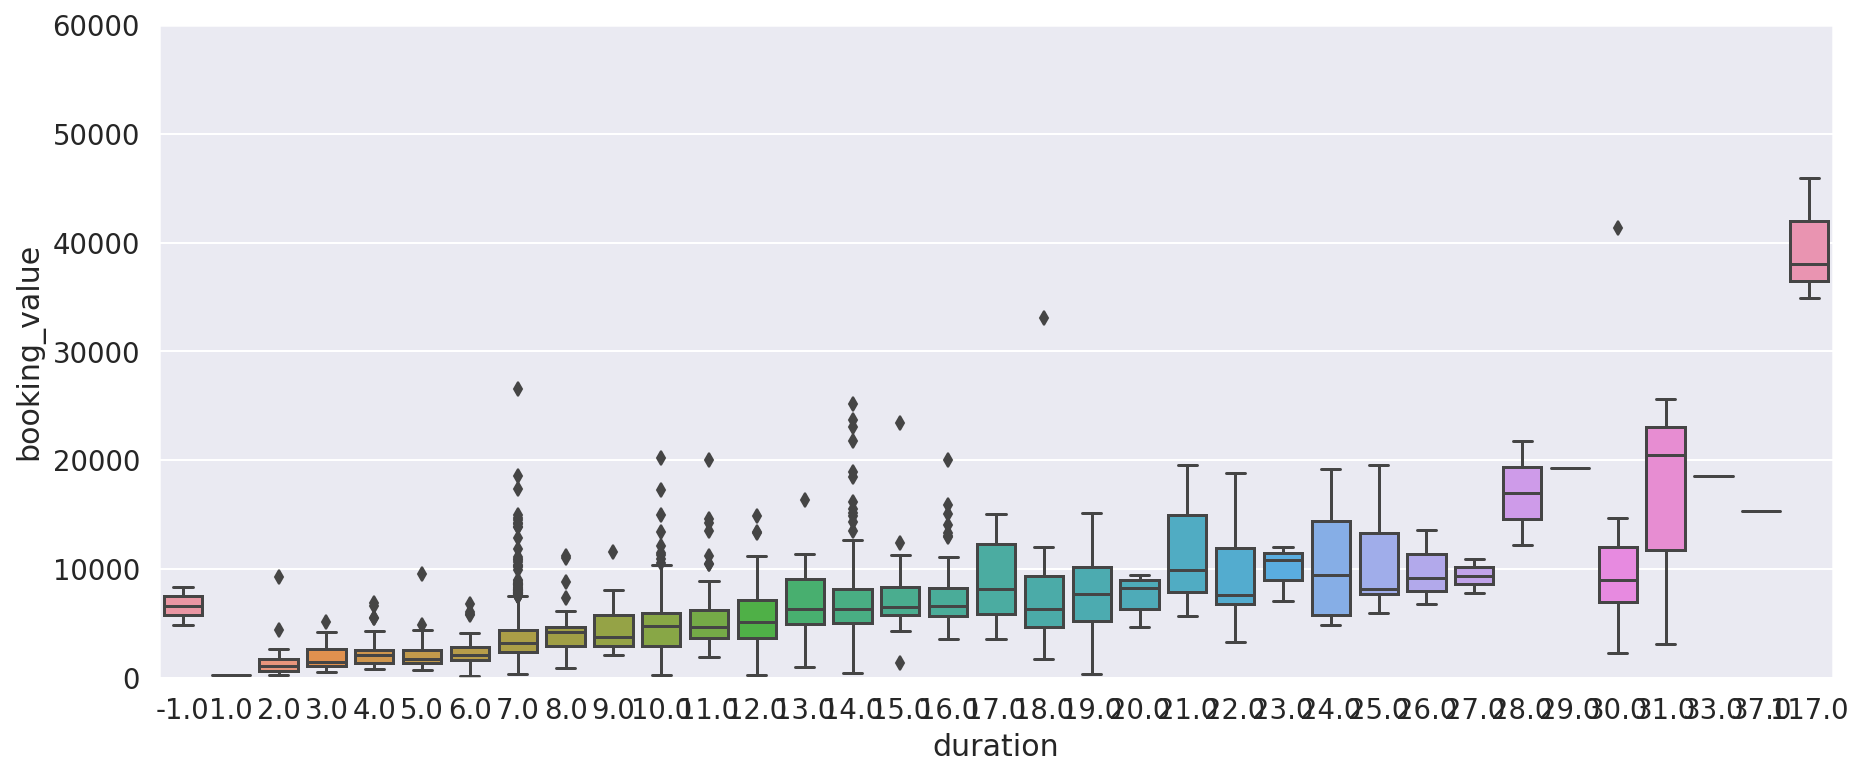

In [64]:

var = 'duration'
data = pd.concat([new_data_bb['booking_value'], new_data_bb[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 6))
fig = sns.boxplot(x=var, y="booking_value", data=data)
fig.axis(ymin=0, ymax=60000);

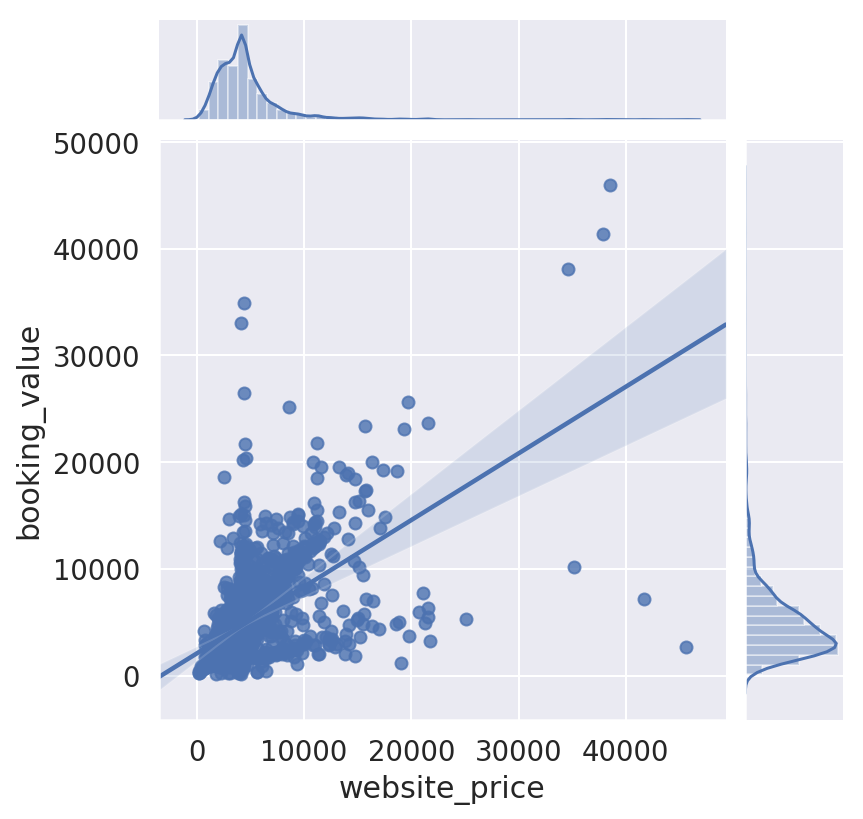

In [66]:
# Living Area vs Sale Price
sns.jointplot(x=new_data_bb['website_price'], y=new_data_bb['booking_value'], kind='reg')

In [67]:
# Removing outliers manually (Two points in the bottom right)
#train = train.drop(train[(train['GrLivArea']>4000) 
 #                        & (train['SalePrice']<300000)].index).reset_index(drop=True)

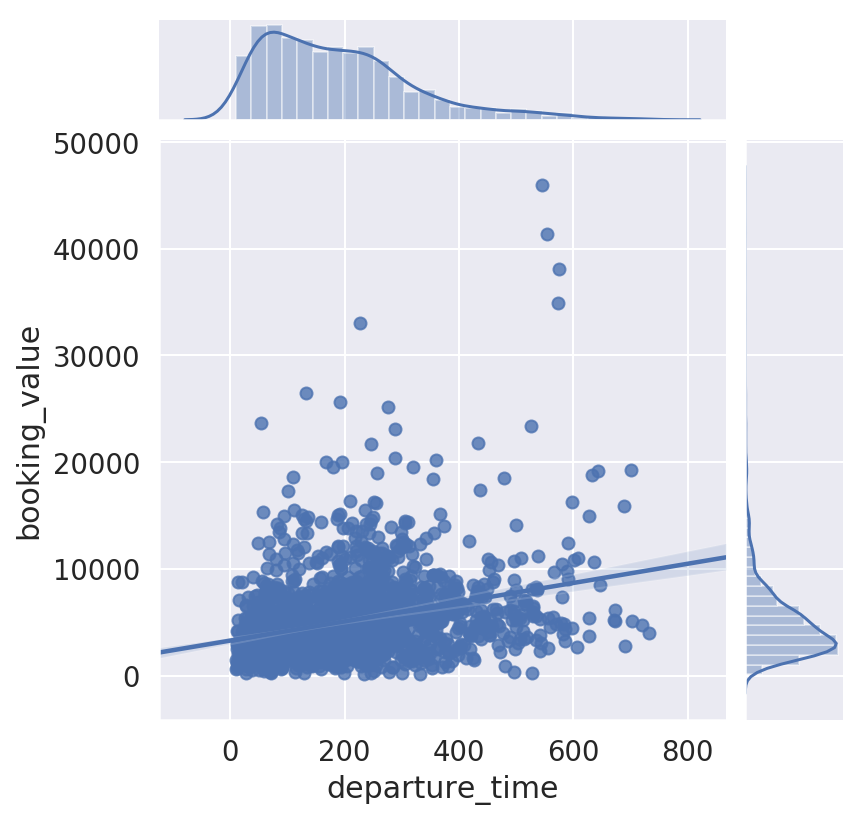

In [68]:
sns.jointplot(x=new_data_bb['departure_time'], y=new_data_bb['booking_value'], kind='reg')

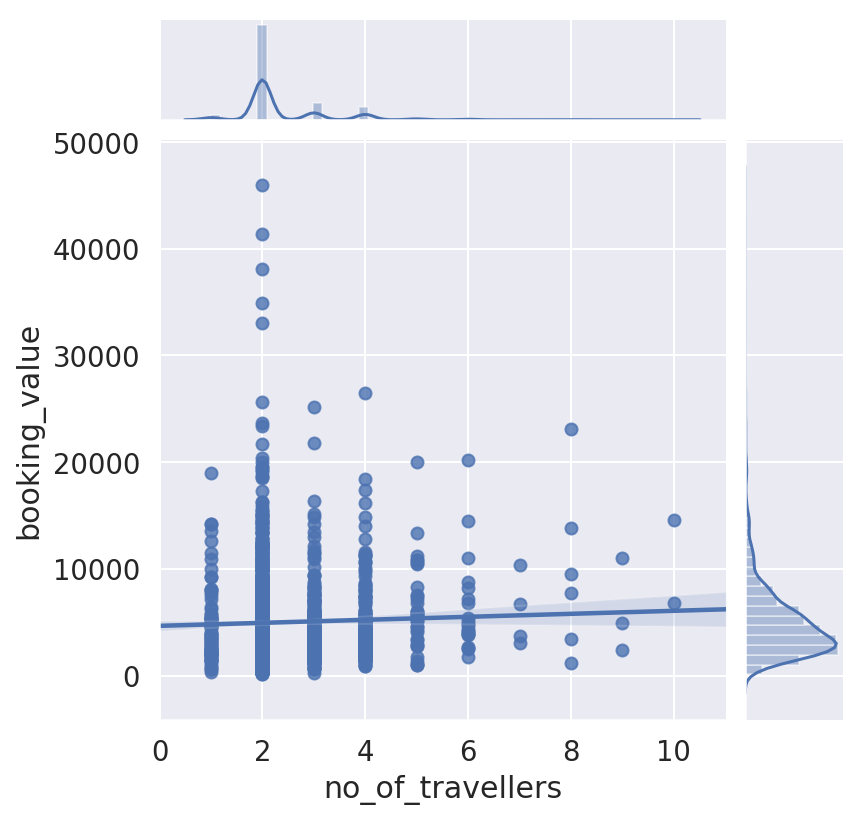

In [69]:
sns.jointplot(x=new_data_bb['no_of_travellers'], y=new_data_bb['booking_value'], kind='reg')

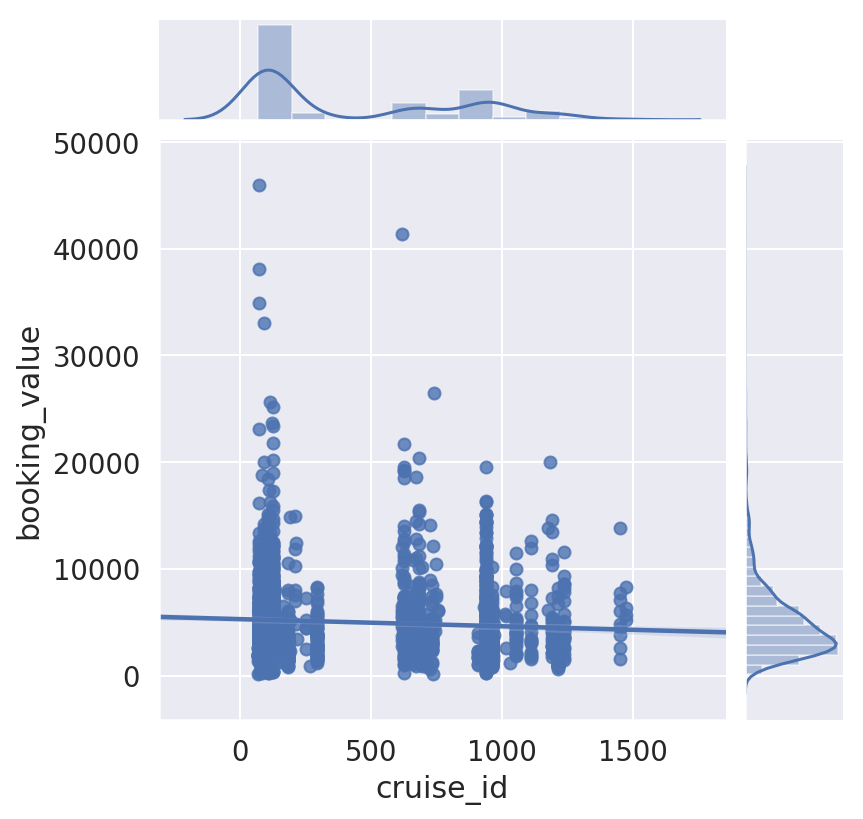

In [70]:
sns.jointplot(x=new_data_bb['cruise_id'], y=new_data_bb['booking_value'], kind='reg')


# Applying log1p to the dataset to make it more balance distribution. The skewness and kurtosis will be decreased after that. Previouly it was more. Now the ditribution is moderatly skewed and looks left side of the distribution is more fatter. Whereas the kurtosis value indicated it has some outliers which may affect the model performance.


 mu = 1.17 and sigma = 0.02



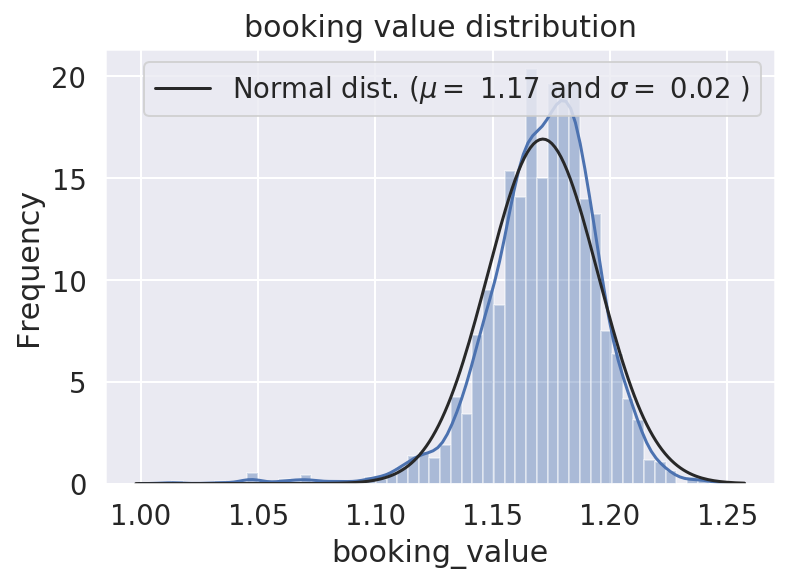

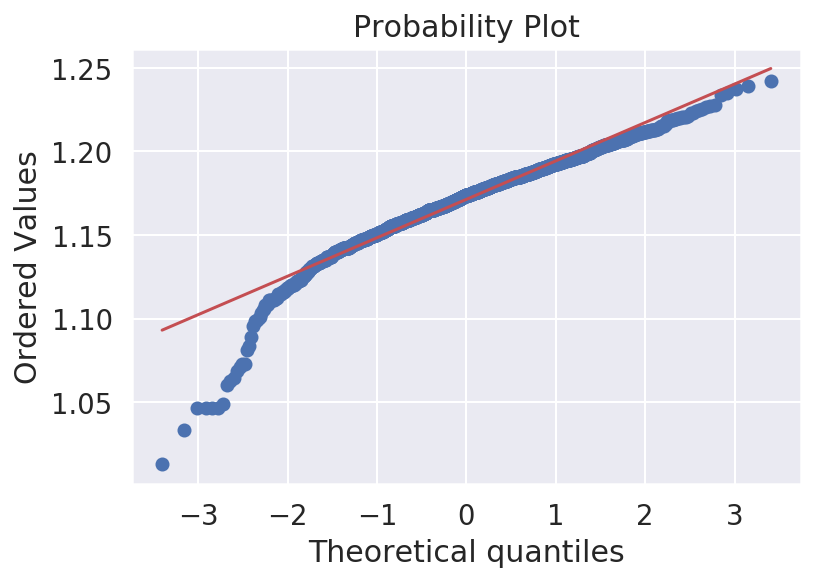

Skewness: -1.091714
Kurtosis: 4.130468


In [73]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
new_data_bb["booking_value"] = np.log1p(new_data_bb["booking_value"])

#Check the new distribution 
sns.distplot(new_data_bb["booking_value"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(new_data_bb["booking_value"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('booking value distribution')

fig = plt.figure()
res = stats.probplot(new_data_bb["booking_value"], plot=plt)
plt.show()

y_train = new_data_bb.booking_value.values

print("Skewness: %f" % new_data_bb["booking_value"].skew())
print("Kurtosis: %f" % new_data_bb["booking_value"].kurt())

# Modeling and Predictions

In [315]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [88]:
#all column except cruise_id
train_x =new_data_bb.iloc[:,:6]
#Only cruise_i
train_y = new_data_bb.iloc[:,6]


In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.20, random_state = 2)

In [148]:
# Cross-validation with k-folds and helper fucntion
from sklearn.model_selection import KFold
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [140]:

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# I tried other algorithm but i got highest accuracy with Gradient Boost algorithm, So i choose this with cross fold validation with fold 5. Other parameters are kind of random with trail and error process.

In [149]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Gradient Boosting score: 0.0143 (0.0016)



# Predicting Booking Probability


I already processed the dataset for predicting vooking probability. 

In [154]:
new_data_bp.head()


,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price
0,2,6.0,234.0,1,737.0,4115.000000
1,2,6.0,332.0,1,71.0,1758.000000
2,2,1.0,28.0,1,107.0,5259.315182
3,2,12.0,246.0,1,72.0,2913.000000
4,2,12.0,198.0,1,938.0,2240.000000


In [185]:
new_data_bp.describe()

,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price
count,19816.000000,19816.000000,19816.000000,19816.000000,19816.000000,1.981600e+04
mean,2.589069,10.003381,206.281619,0.105723,617.056891,6.249410e+03
std,1.129889,9.752048,145.509793,0.307490,442.745111,2.836300e+04
min,1.000000,-1.000000,7.000000,0.000000,71.000000,-1.718833e+05
25%,2.000000,7.000000,92.000000,0.000000,127.000000,2.736000e+03
50%,2.000000,7.000000,183.000000,0.000000,714.000000,4.418667e+03
75%,3.000000,12.000000,281.000000,0.000000,1030.000000,6.788329e+03
max,15.000000,209.000000,871.000000,1.000000,1481.000000,3.667454e+06


In [186]:
print(new_data_bp.shape)
missing_values = new_data_bp.isnull().sum()
missing_values

(19816, 6)


no_of_travellers    0
duration            0
departure_time      0
conversion          0
cruise_id           0
website_price       0
dtype: int64

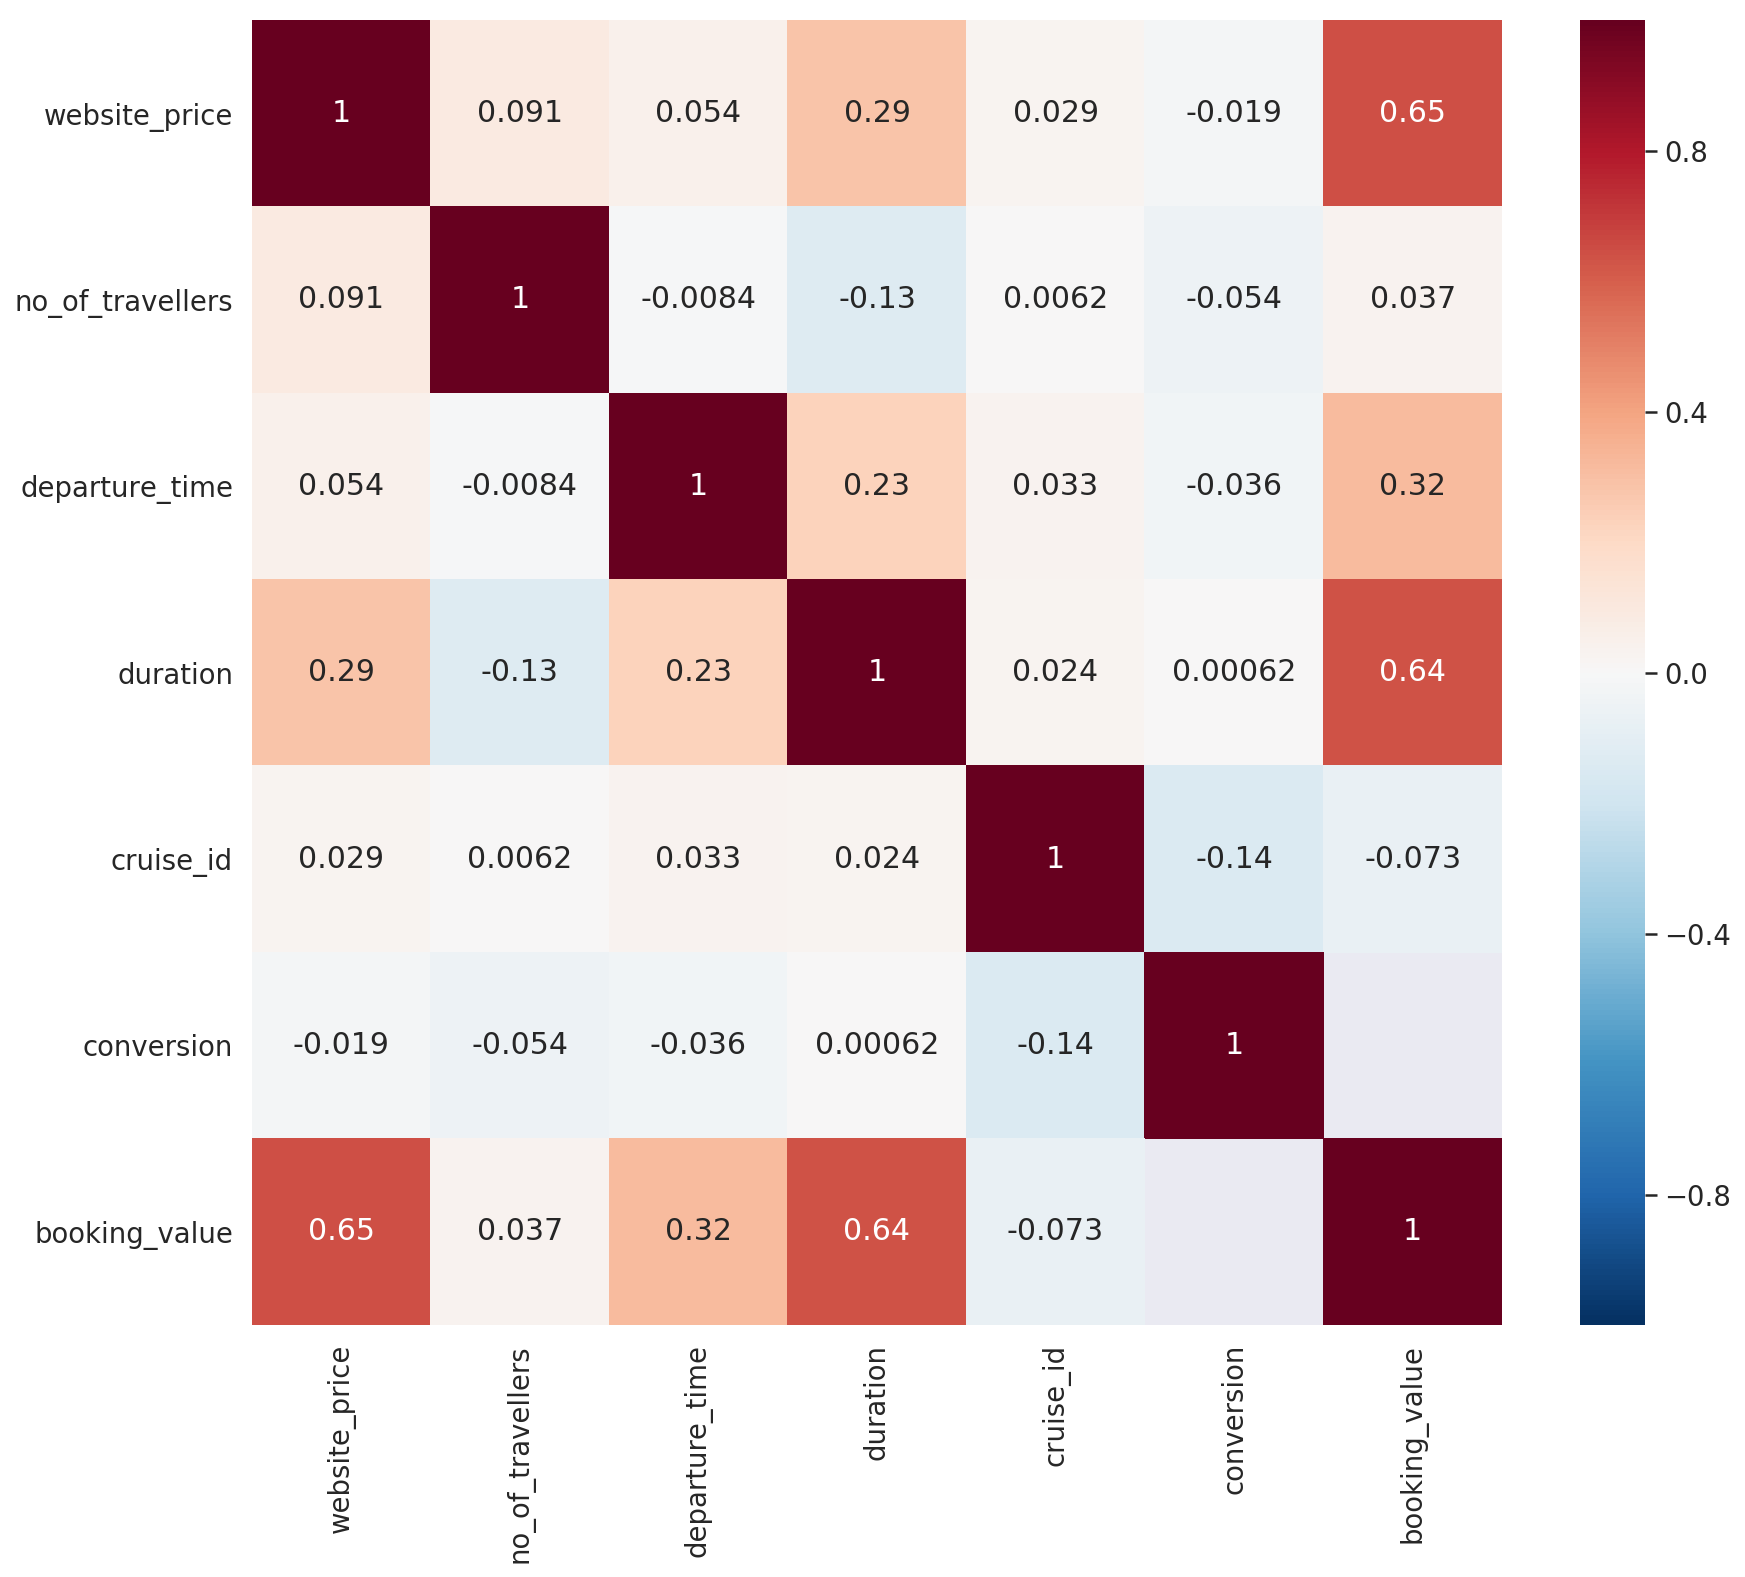

In [187]:
correlation = new_data.corr()
# display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")


 mu = 0.11 and sigma = 0.31



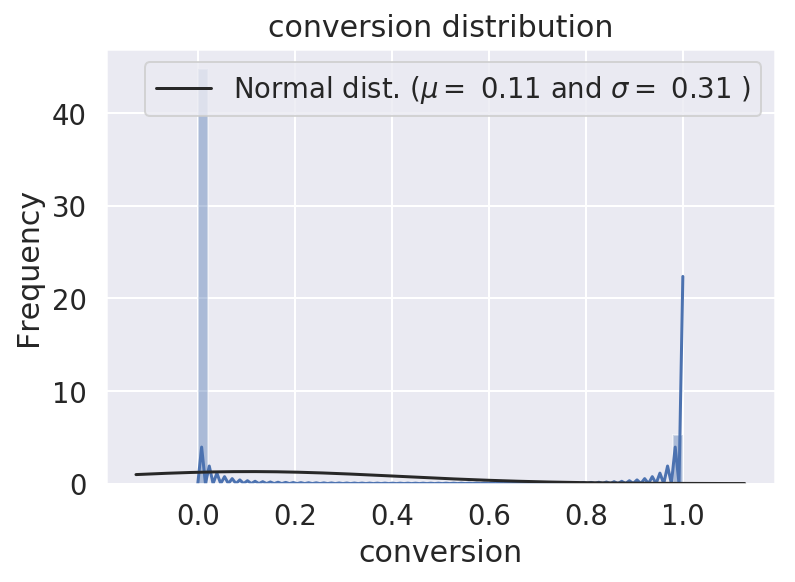

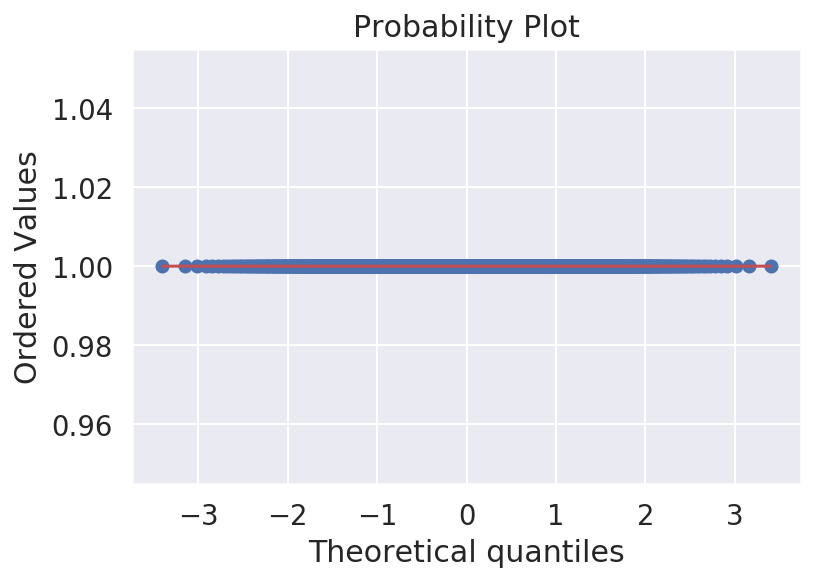

Skewness: 2.564747
Kurtosis: 4.578390


In [188]:
from scipy.stats import norm
# Plot Histogram
sns.distplot(new_data_bp['conversion'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(new_data_bp['conversion'] )
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('conversion distribution')

fig = plt.figure()
res = stats.probplot(new_data_bb['conversion'], plot=plt)
plt.show()

print("Skewness: %f" % new_data_bp['conversion'].skew())
print("Kurtosis: %f" % new_data_bp['conversion'].kurt())

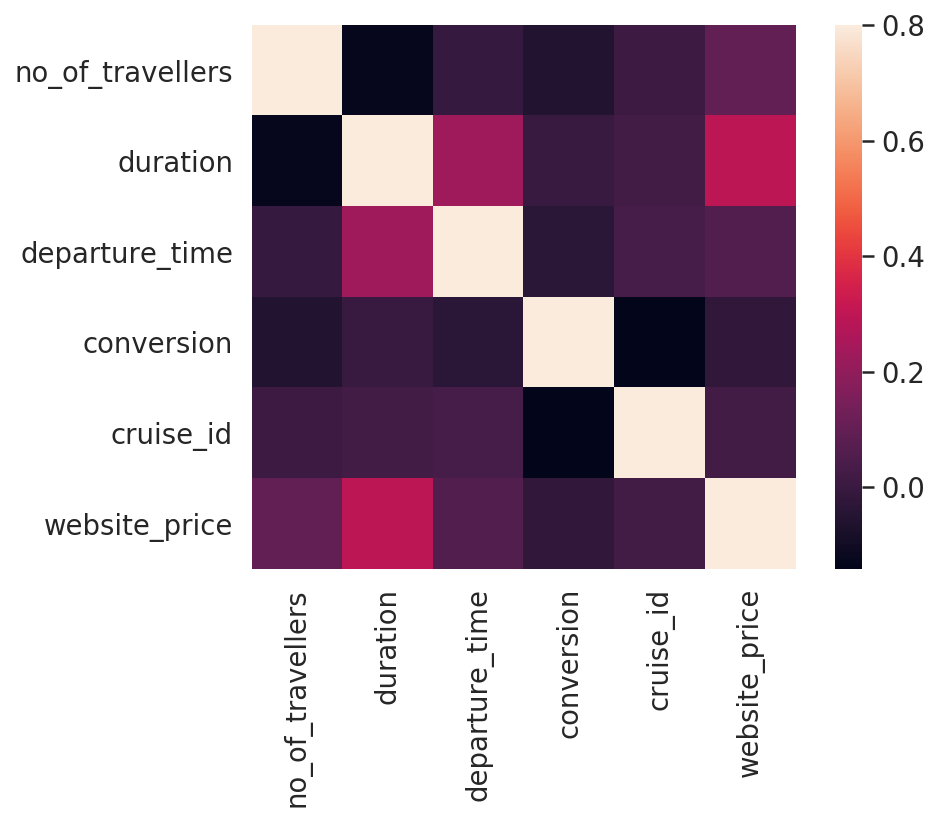

In [191]:
# Correlation Matrix Heatmap
corrmat = new_data_bp.corr()
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

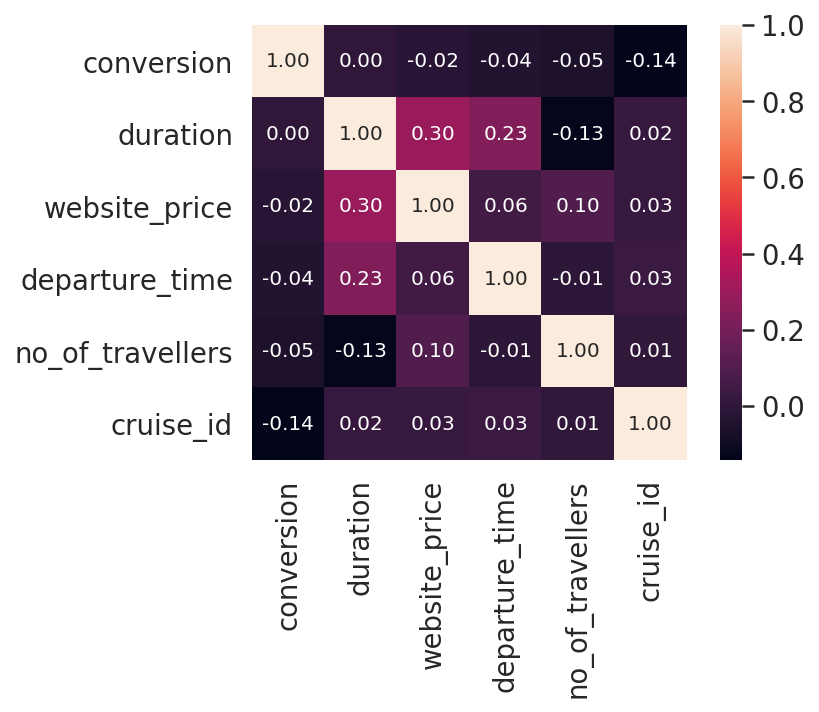

In [192]:
# Top 10 Heatmap
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'conversion')['conversion'].index
cm = np.corrcoef(new_data_bp[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [193]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,conversion
1,duration
2,website_price
3,departure_time
4,no_of_travellers
5,cruise_id


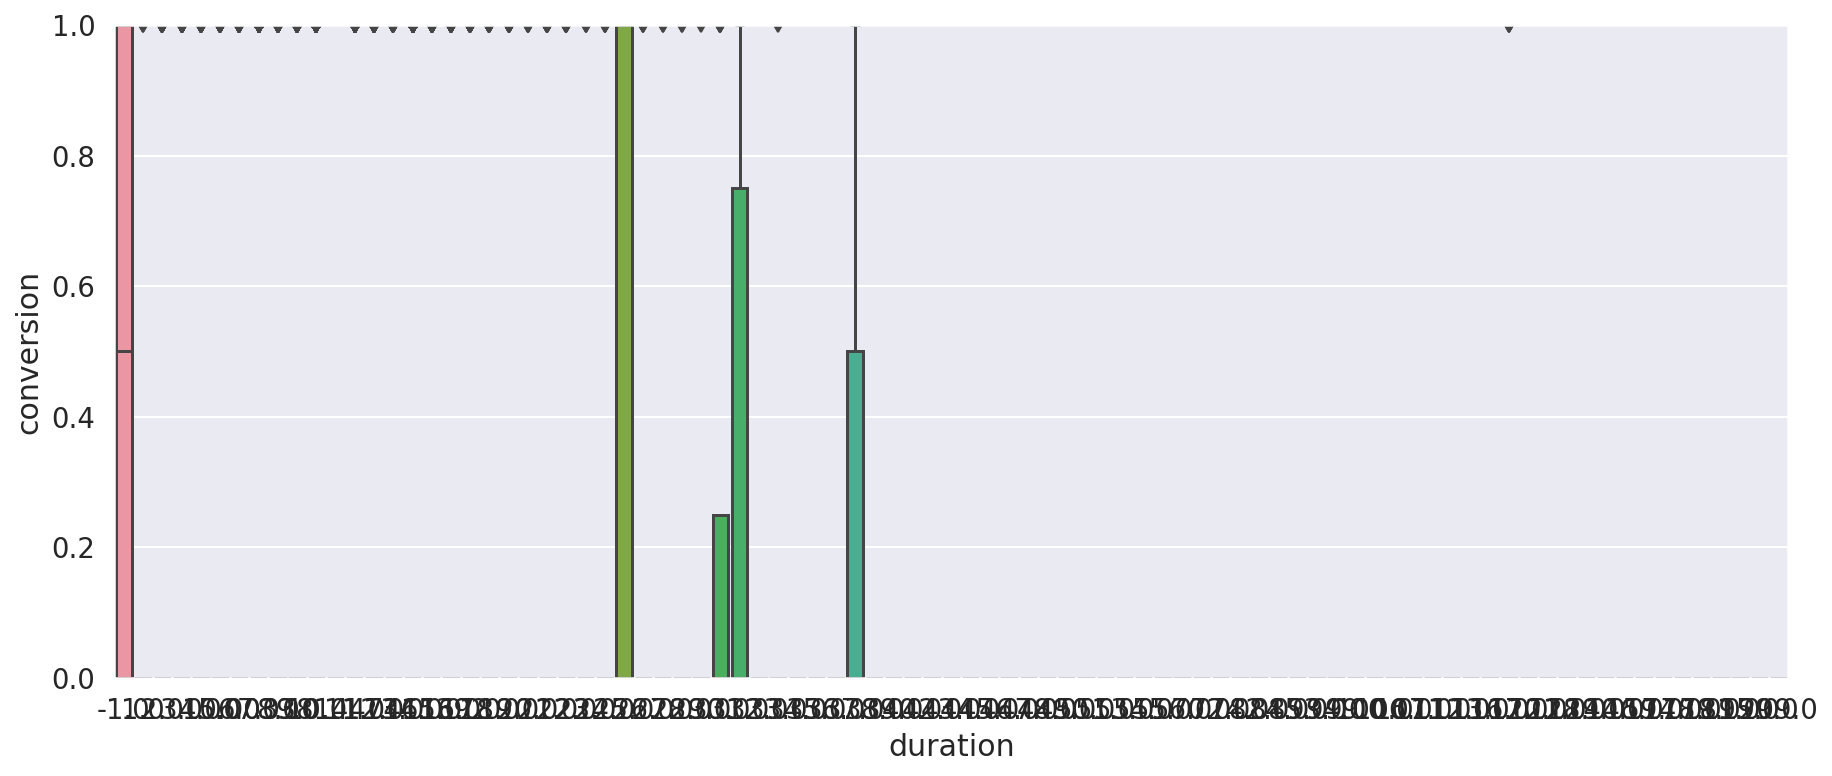

In [194]:
# duration vs Sale Price
var = 'duration'
data = pd.concat([new_data_bp['conversion'], new_data_bp[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 6))
fig = sns.boxplot(x=var, y="conversion", data=data)
fig.axis(ymin=0, ymax=1);

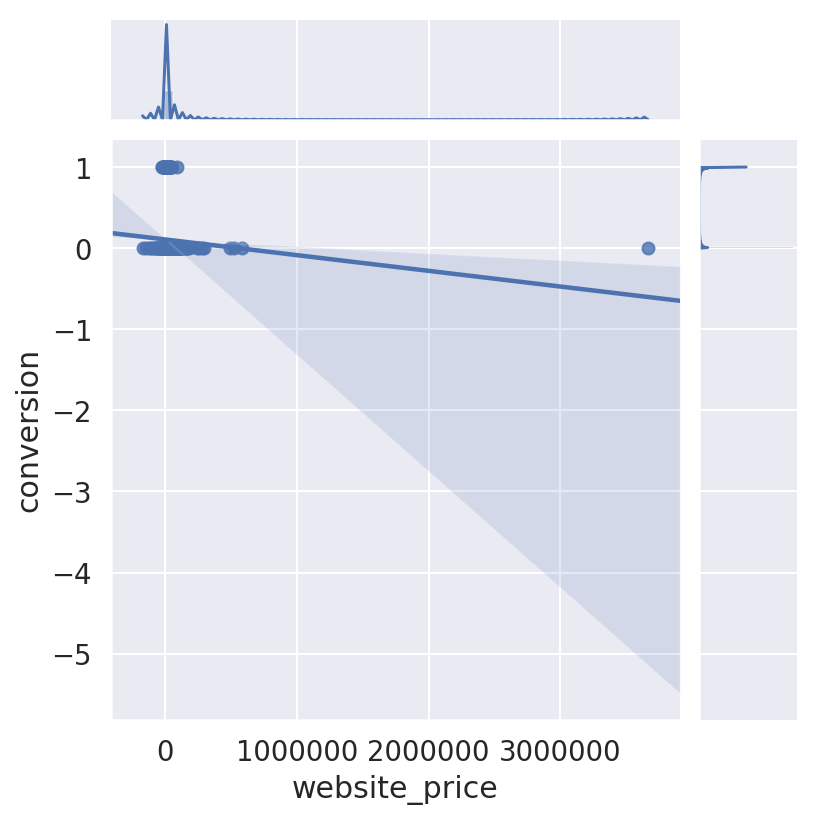

In [195]:
# Living Area vs Sale Price
sns.jointplot(x=new_data_bp['website_price'], y=new_data_bp['conversion'], kind='reg')

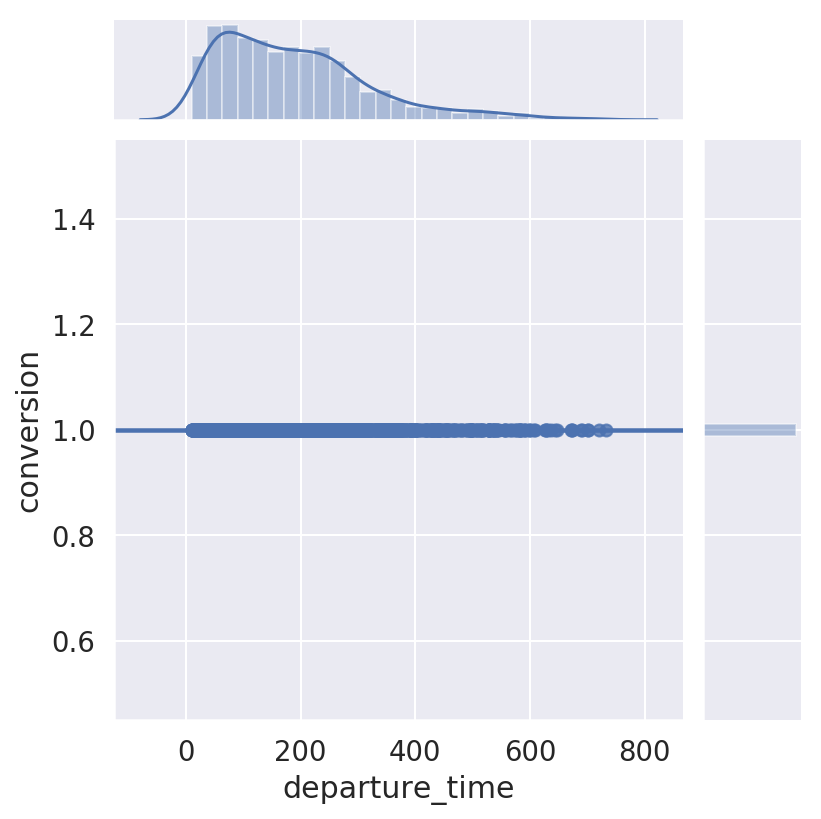

In [196]:
sns.jointplot(x=new_data_bb['departure_time'], y=new_data_bb['conversion'], kind='reg')

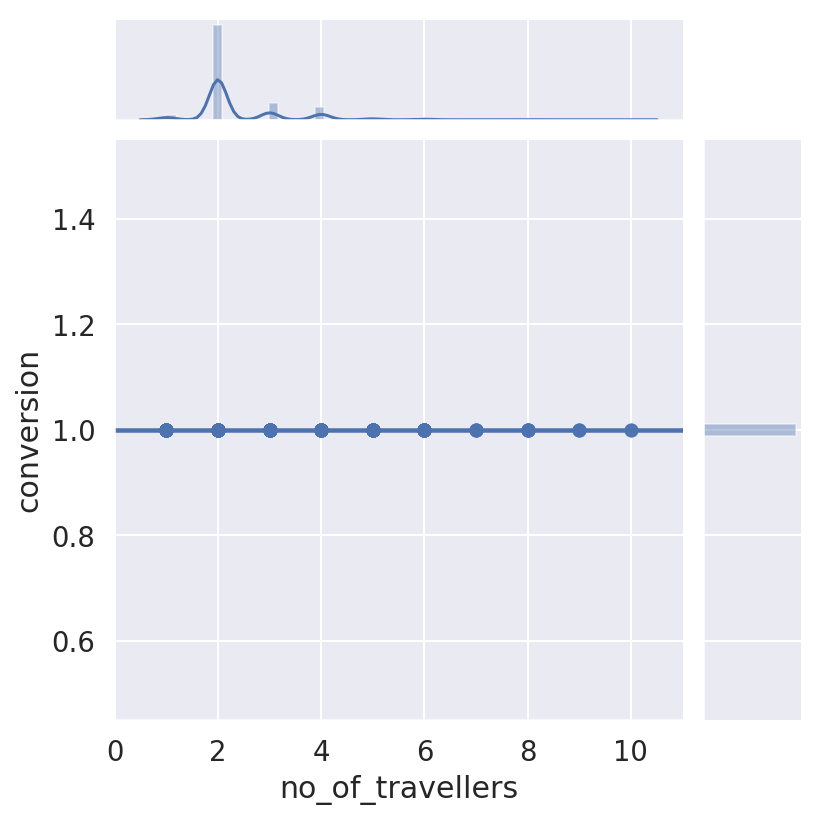

In [197]:

sns.jointplot(x=new_data_bb['no_of_travellers'], y=new_data_bb['conversion'], kind='reg')

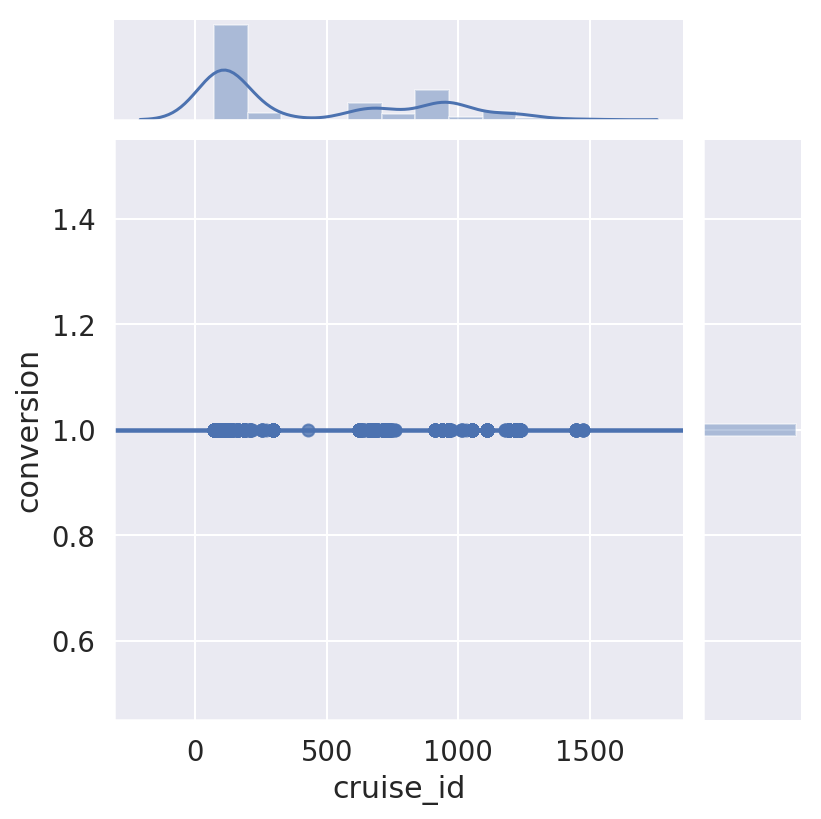

In [198]:
sns.jointplot(x=new_data_bb['cruise_id'], y=new_data_bb['conversion'], kind='reg')

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

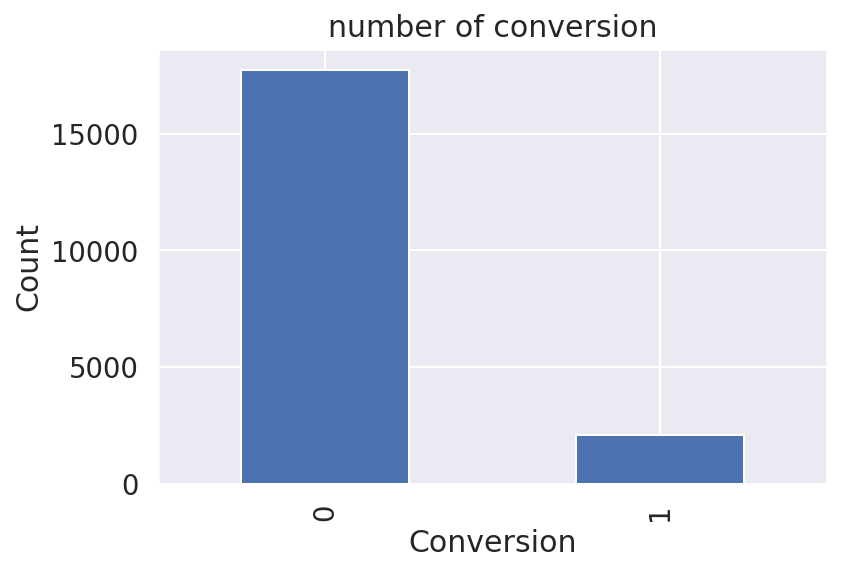

In [205]:
new_data_bp['conversion'].value_counts().plot(kind='bar')
plt.title('number of conversion')
plt.xlabel('Conversion')
plt.ylabel('Count')
sns.despine

In [252]:
new_data_bp.head()

,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price
0,2,6.0,234.0,1,737.0,4115.000000
1,2,6.0,332.0,1,71.0,1758.000000
2,2,1.0,28.0,1,107.0,5259.315182
3,2,12.0,246.0,1,72.0,2913.000000
4,2,12.0,198.0,1,938.0,2240.000000


In [262]:
#all column except cruise_id
train_x =new_data_bp.iloc[:,[0,1,2,4,5]].values
#Only cruise_id
train_y = new_data_bp.iloc[:,3].values

In [263]:
print(train_x.shape, train_y.shape)


(19816, 5) (19816,)


In [264]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.20, random_state = 2)

# Evaluate using a train and a test set:

In [269]:
print(X_train.shape, y_train.shape)

(15852, 5) (15852,)


Naive-Bayes accuracy :  0.5903128153380424


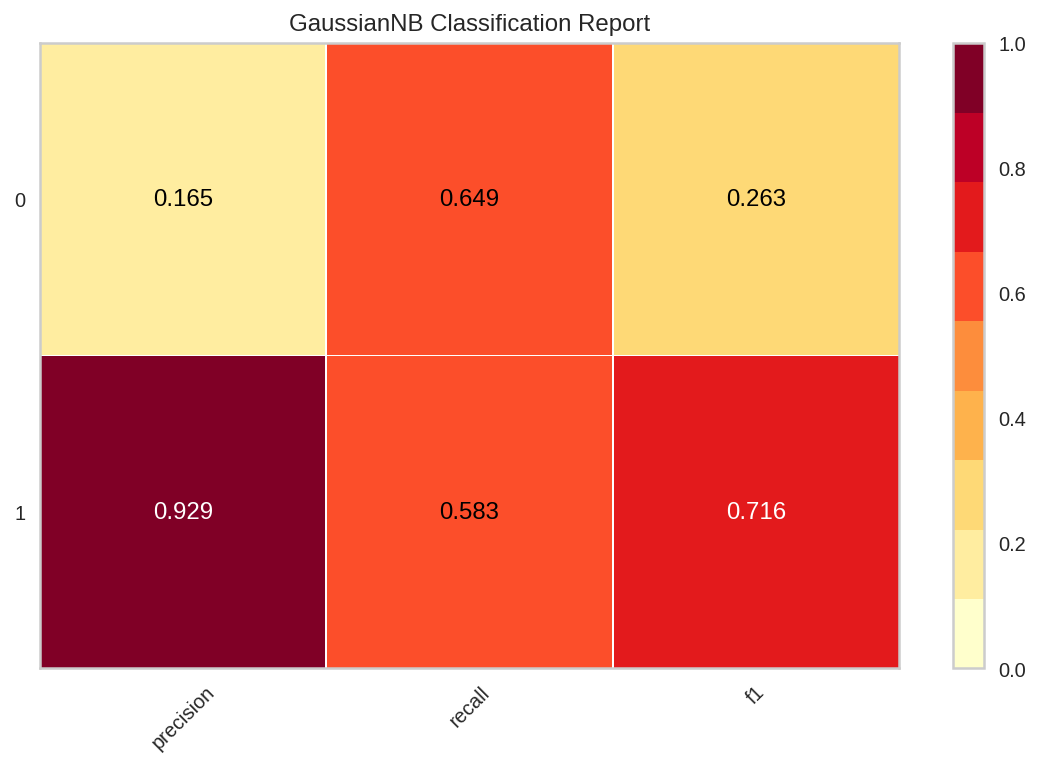

[[2050 1467]
 [ 157  290]]


In [292]:
# import the necessary module
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
#create an object of the type GaussianNB
gnb = GaussianNB()
#train the algorithm on training data and predict using the testing data
pred = gnb.fit(X_train, y_train).predict(X_test)
#print(pred.tolist())
#print the accuracy score of the model
print("Naive-Bayes accuracy : ",accuracy_score(y_test, pred, normalize = True))

from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=['1','0'])
visualizer.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred))

In [275]:
X_train

array([[2.00000000e+00, 1.50000000e+01, 2.92000000e+02, 9.38000000e+02,
        4.48300000e+03],
       [2.00000000e+00, 7.00000000e+00, 2.19000000e+02, 1.03000000e+03,
        1.36500000e+03],
       [1.00000000e+00, 1.40000000e+01, 9.20000000e+01, 1.84000000e+02,
        9.18000000e+03],
       ...,
       [2.00000000e+00, 2.00000000e+01, 1.19000000e+02, 1.09100000e+03,
        4.42175213e+03],
       [2.00000000e+00, 7.00000000e+00, 4.80000000e+01, 1.15000000e+02,
        1.48600000e+03],
       [2.00000000e+00, 1.80000000e+01, 2.93000000e+02, 1.14000000e+02,
        1.85823205e+03]])

LinearSVC accuracy :  0.886226034308779


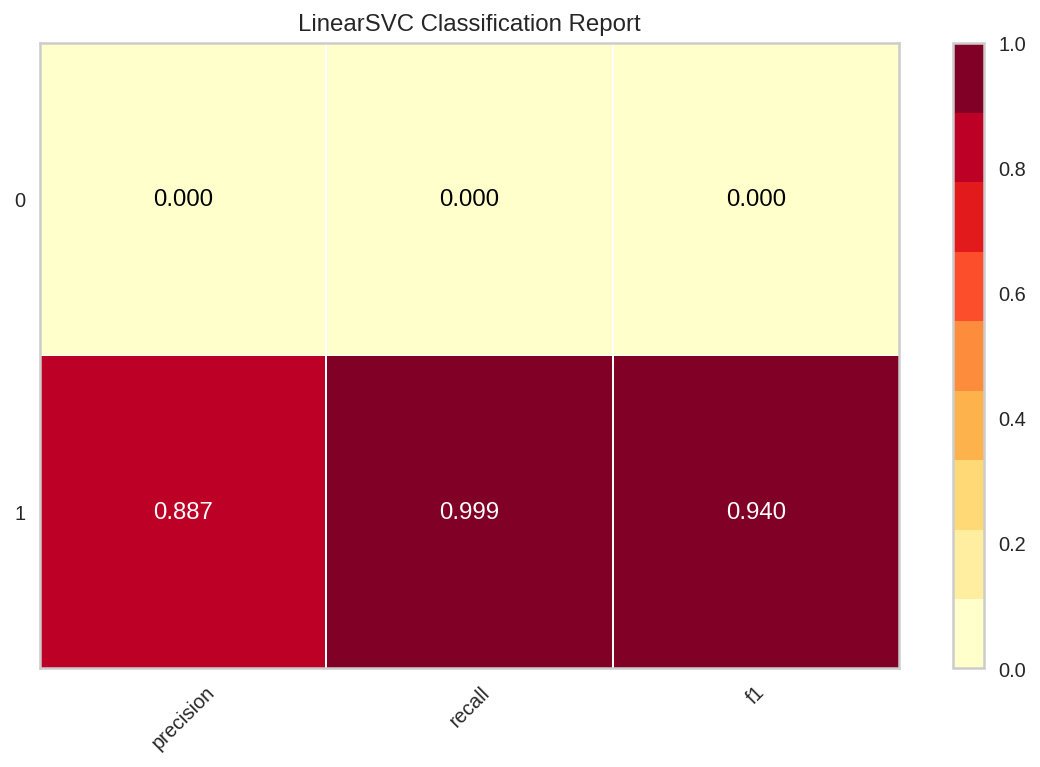

[[3513    4]
 [ 447    0]]


In [293]:
#Linear SVC

#import the necessary modules
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
#create an object of type LinearSVC
svc_model = LinearSVC(random_state=0)
#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(X_train, y_train)
pred = svc_model.predict(X_test)
#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(y_test, pred, normalize = True))

from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svc_model, classes=['1','0'])
visualizer.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred))

KNeighbors accuracy score :  0.855196770938446


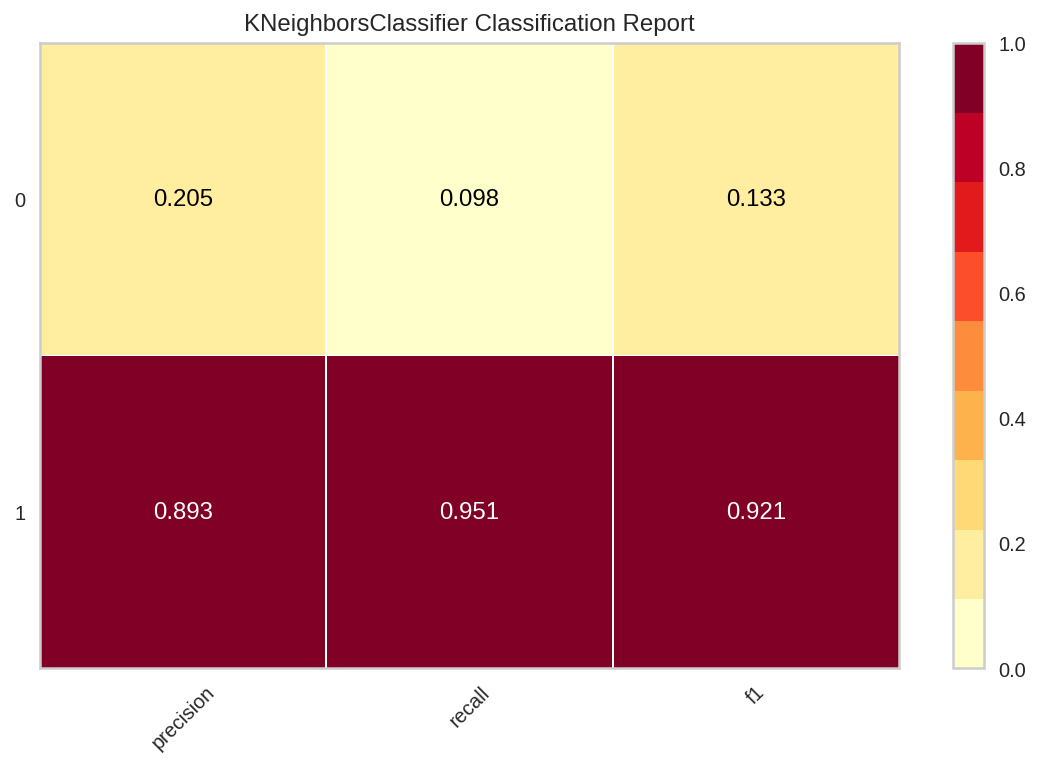

[[3346  171]
 [ 403   44]]


In [294]:
#import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#create object of the lassifier
neigh = KNeighborsClassifier(n_neighbors=3)
#Train the algorithm
neigh.fit(X_train, y_train)
# predict the response
pred = neigh.predict(X_test)
# evaluate accuracy
print ("KNeighbors accuracy score : ",accuracy_score(y_test, pred))


from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(neigh, classes=['1','0'])
visualizer.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred))

In [306]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
#Feature Extraction
# feature extraction
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()
print(model.feature_importances_)
print ("KNeighbors accuracy score : ",accuracy_score(y_test, pred))

Learning rate:  0.05
Accuracy score (training): 0.896
Accuracy score (validation): 0.887

Learning rate:  0.1
Accuracy score (training): 0.896
Accuracy score (validation): 0.887

Learning rate:  0.25
Accuracy score (training): 0.896
Accuracy score (validation): 0.887

Learning rate:  0.5
Accuracy score (training): 0.896
Accuracy score (validation): 0.887

Learning rate:  0.75
Accuracy score (training): 0.896
Accuracy score (validation): 0.886

Learning rate:  1
Accuracy score (training): 0.896
Accuracy score (validation): 0.885

[0.04166569 0.08148656 0.09783039 0.50706107 0.27195629]
KNeighbors accuracy score :  0.8854692230070635


In [310]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
#Feature Extraction
# feature extraction
for learning_rate in learning_rates:
    gb = RandomForestClassifier(n_estimators=100, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print(gb.predict(X_test))
print(model.feature_importances_)
print ("Forest accuracy score : ",accuracy_score(y_test, pred))

Learning rate:  0.05
Accuracy score (training): 0.896
Accuracy score (validation): 0.887
[0 0 0 ... 0 0 0]
Learning rate:  0.1
Accuracy score (training): 0.896
Accuracy score (validation): 0.887
[0 0 0 ... 0 0 0]
Learning rate:  0.25
Accuracy score (training): 0.896
Accuracy score (validation): 0.887
[0 0 0 ... 0 0 0]
Learning rate:  0.5
Accuracy score (training): 0.896
Accuracy score (validation): 0.887
[0 0 0 ... 0 0 0]
Learning rate:  0.75
Accuracy score (training): 0.896
Accuracy score (validation): 0.887
[0 0 0 ... 0 0 0]
Learning rate:  1
Accuracy score (training): 0.896
Accuracy score (validation): 0.887
[0 0 0 ... 0 0 0]
[0.04166569 0.08148656 0.09783039 0.50706107 0.27195629]
Forest accuracy score :  0.8854692230070635


In [309]:
# ROC curve and Area-Under-Curve (AUC)

y_scores_gb = gb.decision_function(X_validation_sub)
fpr_gb, tpr_gb, _ = roc_curve(y_validation_sub, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [311]:

# the lower the price, the more likely I am going to buy
new_data_bp['booking_probability'] = 1 - new_data_bp['duration'] * 0.1

In [313]:
new_data_bp

,no_of_travellers,duration,departure_time,conversion,cruise_id,website_price,booking_probability
0,2,6.0,234.0,1,737.000000,4115.000000,0.4
1,2,6.0,332.0,1,71.000000,1758.000000,0.4
2,2,1.0,28.0,1,107.000000,5259.315182,0.9
3,2,12.0,246.0,1,72.000000,2913.000000,-0.2
4,2,12.0,198.0,1,938.000000,2240.000000,-0.2
5,2,10.0,301.0,1,938.000000,3810.000000,0.0
6,3,1.0,528.0,1,86.000000,198.000000,0.9
7,2,2.0,71.0,1,110.000000,244.000000,0.8
8,2,12.0,128.0,1,625.000000,3137.000000,-0.2
9,2,2.0,70.0,1,110.000000,266.000000,0.8
